#  Proyecto Final CallMeMaybe

## Objetivo del proyecto
El servicio de telefonía virtual **CallMeMaybe** busca identificar a los operadores menos eficaces con el fin de:
- Reducir el número de llamadas entrantes perdidas.  
- Disminuir el tiempo de espera de los clientes antes de ser atendidos.  
- Mejorar la productividad en llamadas salientes cuando corresponde.  

## Definición de ineficacia
Un operador se considera ineficaz si:
1. Presenta una **alta tasa de llamadas entrantes perdidas**.  
2. Mantiene **tiempos de espera elevados** en llamadas entrantes.  
3. En caso de que deba realizar llamadas salientes, realiza un **bajo volumen de ellas**.  

### Importar librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Paso 1. Exploración de datos

In [3]:
# Se cargan datasets
calls = pd.read_csv("../data/raw/telecom_dataset_us.csv")
clients = pd.read_csv("../data/raw/telecom_clients_us.csv")

### 1.1 Calls

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [5]:
calls.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [6]:
# Valores ausentes
calls.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [7]:
# Valores duplicados
calls.duplicated().sum()

np.int64(4900)

In [8]:
# Convertir el dytipe de la columna date 
calls['date'] = pd.to_datetime(calls['date'], utc=True, errors='coerce').dt.tz_convert(None)
clients['date_start'] = pd.to_datetime(clients['date_start'], utc=True, errors='coerce').dt.tz_convert(None)


In [9]:
# Se eliminan datos duplicados
rows_antes = len(calls)
calls = calls.drop_duplicates()
rows_despues = len(calls)
print(f"Duplicados eliminados: {rows_antes - rows_despues} | Filas finales: {rows_despues}")

Duplicados eliminados: 4900 | Filas finales: 49002


In [10]:
# Normalizar columnas categóricas y booleans
# se evita errores en filtros o agrupaciones y mantenemos consistencia.

calls['direction'] = calls['direction'].astype(str).str.lower().str.strip()

calls['internal'] = calls['internal'].astype('boolean').fillna(False).astype(bool)

calls['is_missed_call'] = calls['is_missed_call'].astype(bool)
 
print("Valores únicos direction:", calls['direction'].unique())
print("Internal nulos después:", calls['internal'].isna().sum())
print("is_missed_call tipo:", calls['is_missed_call'].dtype)


Valores únicos direction: ['in' 'out']
Internal nulos después: 0
is_missed_call tipo: bool


In [11]:
# Ajustar operator_id a Int64 (nullable)

calls['operator_id'] = calls['operator_id'].astype('Int64')

print("Tipo de operator_id:", calls['operator_id'].dtype)
print("Nulos en operator_id:", calls['operator_id'].isna().sum())


Tipo de operator_id: Int64
Nulos en operator_id: 7456


### Clients

### Tratamiento de operator_id

- Situación: 7.456 registros (~14%) no tienen operator_id asignado.  
- Interpretación: estas son llamadas que no fueron atendidas por ningún operador (ejemplo: perdidas en cola).  
- Política adoptada:
  - En métricas globales (nivel cliente/empresa), se incluyen porque reflejan la realidad del servicio.  
  - En métricas por operador, se excluyen para no penalizar a personas con llamadas que nunca recibieron.  
- Implementación: mantener los valores nulos y convertir la columna a tipo entero **`Int64`** (nullable), que soporta `NaN`.


In [12]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [13]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [14]:
# Valores ausentes
clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [15]:
# Valores duplicados
clients.duplicated().sum()

np.int64(0)

### Conclusión

- El dataset de **calls** fue revisado en detalle:
  - Se normalizaron las fechas a formato estándar.
  - Se eliminaron duplicados (9% de los registros).
  - Se limpiaron y tipificaron las variables categóricas y booleanas (`direction`, `internal`, `is_missed_call`).
  - Se ajustó `operator_id` a tipo entero con soporte de valores nulos (7.456 registros sin asignación, que se considerarán como "llamadas no atendidas y no atribuibles a operadores").
- El dataset de **clients** no presentó problemas:
  - Sin valores ausentes ni duplicados.
  - Fechas (`date_start`) ya en formato correcto.
  - Dataset listo para análisis.
 
Los datos fueron validados, limpiados y estandarizados, lo que garantiza que los análisis posteriores se realicen sobre información consistente y confiable. 


## PASO 2 Diagnóstico inicial

**Objetivo:**  
Explorar el comportamiento general de las llamadas para detectar primeras señales de ineficacia en el servicio.

**Preguntas clave:**  
1. ¿Cuál es el volumen de llamadas por tipo (`in`, `out`, `internal`)?  
2. ¿Qué proporción de llamadas entrantes se pierden?  
3. ¿Cómo varía la duración de las llamadas y el tiempo de espera?  
4. ¿Existen clientes con patrones atípicos de uso o desempeño?  

### 2.1 Volumen de llamadas

In [16]:
#  Volumen por dirección (in / out)
volumen_dir = (
    calls.groupby("direction")["calls_count"]
    .sum()
    .reset_index(name="n_llamadas")
)

total_dir = volumen_dir["n_llamadas"].sum()
volumen_dir["proporcion"] = (volumen_dir["n_llamadas"] / total_dir * 100).round(2)

volumen_dir.to_csv("volumen_llamadas.csv", index=False)

volumen_dir


,direction,n_llamadas,proporcion
0,in,197845,24.52
1,out,608864,75.48


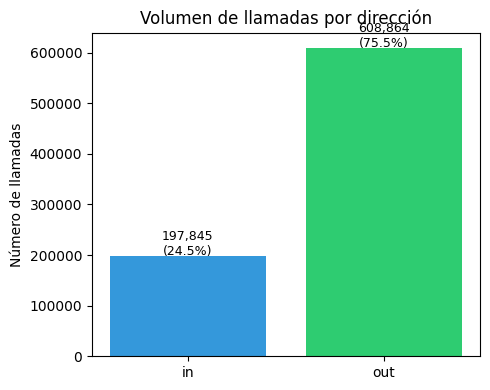

In [17]:

plt.figure(figsize=(5,4))
bars = plt.bar(volumen_dir["direction"], volumen_dir["n_llamadas"], color=["#3498db","#2ecc71"])

plt.title("Volumen de llamadas por dirección")
plt.ylabel("Número de llamadas")

for i, bar in enumerate(bars):
    valor = volumen_dir["n_llamadas"].iloc[i]
    pct = volumen_dir["proporcion"].iloc[i]
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
             f"{valor:,}\n({pct:.1f}%)",
             ha="center", fontsize=9)

plt.tight_layout()
plt.show()


In [18]:
# Solo llamadas entrantes intervas vs externas
in_calls = calls[calls["direction"] == "in"]

volumen_in = (
    in_calls.groupby("internal")["calls_count"]
    .sum()
    .reset_index(name="n_llamadas")
)

volumen_in["tipo"] = volumen_in["internal"].map({True: "interna", False: "externa"})

total_in = volumen_in["n_llamadas"].sum()
volumen_in["proporcion"] = (volumen_in["n_llamadas"] / total_in * 100).round(2)

volumen_in = volumen_in[["tipo", "n_llamadas", "proporcion"]]

volumen_in



,tipo,n_llamadas,proporcion
0,externa,196224,99.18
1,interna,1621,0.82


#### Conclusión 

El análisis muestra que:

Las llamadas salientes representan tres de cada cuatro llamadas realizadas por la empresa (≈75%).

Dentro de las entrantes, casi la totalidad (≈99%) son externas, es decir, de clientes reales.

Las llamadas internas son mínimas y no tienen impacto operativo relevante.

La operación está enfocada en llamadas salientes, pero el verdadero foco de gestión deberían ser las entrantes externas, ya que representan la interacción con los clientes y su experiencia directa con la empresa.

### PASO 2.2 Tasas de llamadas perdidas

In [19]:
# Proporción de las llamadas entrantes externas  terminan en llamadas perdidas
# Filtrar solo llamadas entrantes externas (clientes reales)
in_ext = calls[(calls["direction"] == "in") & (~calls["internal"])].copy()

total_in = in_ext["calls_count"].sum()
missed_in = in_ext.loc[in_ext["is_missed_call"], "calls_count"].sum()

miss_rate_global = round((missed_in / total_in) * 100, 2)

resumen_perdidas = pd.DataFrame({
    "total_entrantes": [total_in],
    "perdidas": [missed_in],
    "tasa_perdida (%)": [miss_rate_global]
})

resumen_perdidas

,total_entrantes,perdidas,tasa_perdida (%)
0,196224,103379,52.68


In [20]:
total_in = resumen_perdidas.loc[0, "total_entrantes"]
missed_in = resumen_perdidas.loc[0, "perdidas"]
attended_in = total_in - missed_in

tasa_global_df = pd.DataFrame({
    "estado": ["Atendidas", "Perdidas"],
    "n_llamadas": [attended_in, missed_in]
})
tasa_global_df["proporcion"] = (tasa_global_df["n_llamadas"] / total_in * 100).round(2)

tasa_global_df.to_csv("tasa_global.csv", index=False)
tasa_global_df

,estado,n_llamadas,proporcion
0,Atendidas,92845,47.32
1,Perdidas,103379,52.68


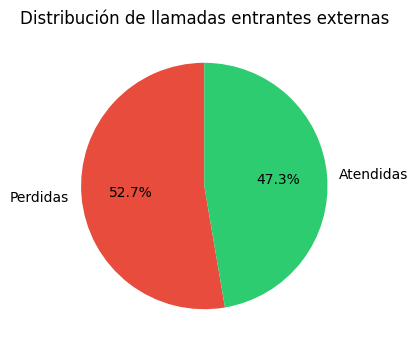

In [21]:

valores = [missed_in, total_in - missed_in]
labels = ["Perdidas", "Atendidas"]

plt.figure(figsize=(4,4))
plt.pie(valores, labels=labels, autopct="%.1f%%", startangle=90, colors=["#e74c3c", "#2ecc71"])
plt.title("Distribución de llamadas entrantes externas")
plt.show()


In [22]:
# Pérdidas por cliente

# entrantes externas
in_ext = calls[(calls["direction"] == "in") & (~calls["internal"])].copy()

# Conteo de pérdidas por fila 
in_ext["missed_count"] = in_ext["calls_count"].where(in_ext["is_missed_call"], 0)

# Agregación por cliente
perdidas_cliente = (
    in_ext.groupby("user_id", as_index=False)
          .agg(total_llamadas=("calls_count", "sum"),
               perdidas=("missed_count", "sum"))
)

perdidas_cliente["tasa_perdida (%)"] = (
    perdidas_cliente["perdidas"] / perdidas_cliente["total_llamadas"] * 100
).round(2)

top_criticos = (perdidas_cliente
                .sort_values(by=["tasa_perdida (%)","total_llamadas"],
                             ascending=[False, False])
                .reset_index(drop=True))



top_criticos.head(10)  


,user_id,total_llamadas,perdidas,tasa_perdida (%)
0,168361,17981,17981,100.0
1,168018,684,684,100.0
2,167125,672,672,100.0
3,167122,450,450,100.0
4,167011,233,233,100.0
5,167285,92,92,100.0
6,168024,68,68,100.0
7,167631,58,58,100.0
8,167077,48,48,100.0
9,167716,42,42,100.0


#### Conclusión 

* A nivel global, más de la mitad de las llamadas entrantes externas (52.7%) se pierden. Esto significa que 1 de cada 2 clientes no logra ser atendido al intentar comunicarse.

* El problema no es homogéneo: hay clientes con tasas de pérdida cercanas al 100%, lo que implica que prácticamente nunca reciben atención.

* Aunque algunos clientes tienen mejores tasas de servicio, el hallazgo central es que las pérdidas son masivas y críticas para la experiencia del cliente.

* Este comportamiento refleja una ineficiencia operativa estructural, con alto riesgo de insatisfacción, pérdida de confianza y fuga de clientes.

* El análisis cliente por cliente nos permite ya priorizar: los más afectados (altos volúmenes + altas tasas de pérdida) deberían ser el foco inmediato de acciones correctivas.

### Paso 2.3. ¿Cómo varía la duración de las llamadas y el tiempo de espera?  

In [45]:
# llamadas entrantes externas
in_ext = calls[(calls["direction"] == "in") & (~calls["internal"])].copy()

# percentiles clave
def percentiles_tabla(serie, nombre_col):
    q = serie.quantile([0.25, 0.50, 0.90, 0.95]).round(2)
    df = q.reset_index()
    df.columns = ["percentil", nombre_col]
    df["percentil"] = (df["percentil"]*100).astype(int).astype(str) + "%"
    return df

duracion_tabla = percentiles_tabla(in_ext["total_call_duration"] / 60, "duracion_llamada_min")

espera_tabla = percentiles_tabla(in_ext["call_duration"] / 60, "tiempo_espera_min")


print("\nTabla — Percentiles de TIEMPO DE ESPERA:")
print(espera_tabla.to_string(index=False))

print("Tabla — Percentiles de DURACIÓN TOTAL de llamadas:")
print(duracion_tabla.to_string(index=False))





Tabla — Percentiles de TIEMPO DE ESPERA:
percentil  tiempo_espera_min
      25%               0.00
      50%               0.97
      90%              23.10
      95%              39.10
Tabla — Percentiles de DURACIÓN TOTAL de llamadas:
percentil  duracion_llamada_min
      25%                  0.63
      50%                  2.50
      90%                 27.76
      95%                 45.17


#### Conclusión 

Tiempo de espera:

* 25% de las llamadas no esperan nada (0 minutos) → esto refleja abandonos inmediatos o colgados instantáneos.
* La mediana es de 58 segundos, lo que indica que la mitad de los clientes debe esperar casi un minuto para obtener respuesta.
* Sin embargo, el problema se dispara en la cola: el 10% más afectado espera más de 23 minutos y el 5% llega a casi 40 minutos.
* Esto muestra un patrón de abandono temprano, combinado con colas críticas para quienes esperan más tiempo.

Duración total de llamadas (incluye espera + conversación):
* El 25% de las llamadas dura menos de 38s, lo que indica contactos extremadamente breves (probablemente abandonos tras pocos segundos).
* La mediana es de 2.5 minutos, representando interacciones típicas que sí llegan a concretarse.
* Nuevamente, la cola larga es dramática: un 10% de llamadas supera los 27 minutos, y un 5% llega hasta 45 minutos.
* Esto confirma que muy pocos clientes son atendidos, pero consumen un tiempo desproporcionado de la operación.

### 2.4. ¿Existen clientes con patrones atípicos de uso o desempeño?  

In [24]:
# Total de llamadas entrantes externas
# PASO 2.4 — Totales base
total_clientes = in_ext["user_id"].nunique()
total_llamadas = in_ext["calls_count"].sum()

print("Clientes únicos:", total_clientes)
print("Total de llamadas entrantes externas:", total_llamadas)


Clientes únicos: 306
Total de llamadas entrantes externas: 196224


#### 2.4.1 Top 5% clientes con mayor volumen de llamadas

In [25]:

vol_por_cliente = in_ext.groupby("user_id", as_index=False)["calls_count"].sum()

umbral_95 = vol_por_cliente["calls_count"].quantile(0.95)

top_clientes = vol_por_cliente[vol_por_cliente["calls_count"] >= umbral_95]

n_top = top_clientes["user_id"].nunique()
llamadas_top = top_clientes["calls_count"].sum()

porc_clientes_top = round(n_top / total_clientes * 100, 2)
porc_llamadas_top = round(llamadas_top / total_llamadas * 100, 2)

print(f"Top 5% clientes por volumen: {n_top} clientes ({porc_clientes_top}%)")
print(f"Volumen que concentran: {llamadas_top:,} llamadas ({porc_llamadas_top}%)")


Top 5% clientes por volumen: 16 clientes (5.23%)
Volumen que concentran: 124,473 llamadas (63.43%)


#### 2.4.2 Clientes con 100% de llamadas perdidas

In [26]:

perdidas_por_cliente = (
    in_ext.groupby("user_id", as_index=False)
          .agg(total_llamadas=("calls_count", "sum"),
               perdidas=("calls_count", lambda x: in_ext.loc[x.index, "calls_count"].where(in_ext.loc[x.index, "is_missed_call"]).sum()))
)

perdidas_por_cliente["tasa_perdida"] = perdidas_por_cliente["perdidas"] / perdidas_por_cliente["total_llamadas"]

clientes_100 = perdidas_por_cliente[perdidas_por_cliente["tasa_perdida"] == 1]

n_loss100 = clientes_100["user_id"].nunique()
llamadas_loss100 = clientes_100["total_llamadas"].sum()

porc_clientes_loss100 = round(n_loss100 / total_clientes * 100, 2)
porc_llamadas_loss100 = round(llamadas_loss100 / total_llamadas * 100, 2)

print(f"Clientes con 100% pérdidas: {n_loss100} clientes ({porc_clientes_loss100}%)")
print(f"Volumen que representan: {llamadas_loss100:,} llamadas ({porc_llamadas_loss100}%)")


Clientes con 100% pérdidas: 33 clientes (10.78%)
Volumen que representan: 20,471 llamadas (10.43%)


#### 2.4.3 Clientes con duración de llamada promedio atípica

In [27]:

duracion_cliente = (
    in_ext.groupby("user_id", as_index=False)
          .agg(total_llamadas=("calls_count", "sum"),
               duracion_promedio=("total_call_duration", "mean"))
)

umbral_duracion = duracion_cliente["duracion_promedio"].quantile(0.95)

clientes_largos = duracion_cliente[duracion_cliente["duracion_promedio"] >= umbral_duracion]

n_largos = clientes_largos["user_id"].nunique()
llamadas_largos = clientes_largos["total_llamadas"].sum()

porc_clientes_largos = round(n_largos / total_clientes * 100, 2)
porc_llamadas_largos = round(llamadas_largos / total_llamadas * 100, 2)

print(f"Clientes con duración promedio muy alta (top 5%): {n_largos} clientes ({porc_clientes_largos}%)")
print(f"Volumen que representan: {llamadas_largos:,} llamadas ({porc_llamadas_largos}%)")


Clientes con duración promedio muy alta (top 5%): 16 clientes (5.23%)
Volumen que representan: 107,090 llamadas (54.58%)


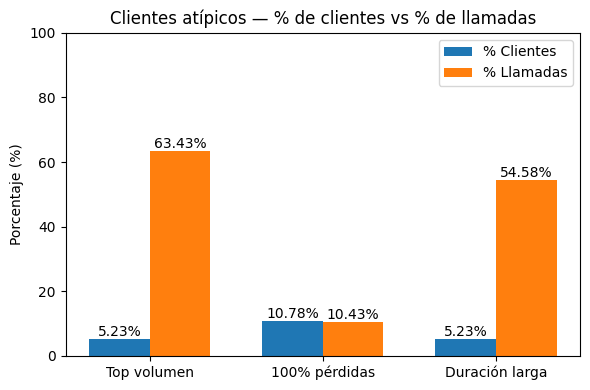

In [28]:

labels = ["Top volumen", "100% pérdidas", "Duración larga"]
pct_clientes = [5.23, 10.78, 5.23]   
pct_llamadas = [63.43, 10.43, 54.58] 

x = range(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
bars1 = plt.bar([i - width/2 for i in x], pct_clientes, width, label="% Clientes")
bars2 = plt.bar([i + width/2 for i in x], pct_llamadas, width, label="% Llamadas")

plt.xticks(list(x), labels)
plt.ylabel("Porcentaje (%)")
plt.ylim(0, 100)  
plt.title("Clientes atípicos — % de clientes vs % de llamadas")
plt.legend()
plt.tight_layout()

def add_labels(bars):
    for b in bars:
        h = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}%", ha="center", va="bottom", fontsize=10)

add_labels(bars1)
add_labels(bars2)

plt.show()


#### Conclusión

El análisis revela patrones atípicos de clientes que distorsionan la operación:

* Unos pocos clientes generan la mayoría de las llamadas, lo que concentra la presión en un segmento reducido.
* Un grupo significativo nunca es atendido, generando riesgo alto de insatisfacción y pérdida de confianza.
* Otro grupo consume tiempos desproporcionados, con llamadas de duración excesiva, comprometiendo la capacidad operativa para el resto.

En conjunto, estos hallazgos muestran que no todos los clientes son afectados igual: mientras algunos concentran y saturan, otros directamente no reciben atención.
Esto sugiere la necesidad de segmentar clientes y aplicar estrategias diferenciadas (priorización, gestión de colas, protocolos especiales para heavy users).

## Paso 3 Análisis de clientes

### Objetivo:
Identificar segmentos de clientes según:

* Volumen de llamadas.
* Tasa de pérdidas.
* Duración promedio.

### 3.1 Volumen de llamadas

In [29]:
# Métricas por cliente
clientes_stats = (
    in_ext.groupby("user_id", as_index=False)
          .agg(
              total_llamadas=("calls_count", "sum"),
              perdidas=("calls_count", lambda x: in_ext.loc[x.index, "calls_count"].where(in_ext.loc[x.index, "is_missed_call"]).sum()),
              duracion_promedio=("total_call_duration", "mean")
          )
)

clientes_stats["tasa_perdida (%)"] = (clientes_stats["perdidas"] / clientes_stats["total_llamadas"] * 100).round(2)

clientes_stats["duracion_promedio_min"] = (clientes_stats["duracion_promedio"] / 60).round(2)

clientes_stats.head()


,user_id,total_llamadas,perdidas,duracion_promedio,tasa_perdida (%),duracion_promedio_min
0,166377,196,94.0,86.627273,47.96,1.44
1,166391,15,11.0,35.928571,73.33,0.60
2,166392,208,106.0,221.260870,50.96,3.69
3,166399,24,11.0,39.450000,45.83,0.66
4,166405,7711,5537.0,1381.537604,71.81,23.03


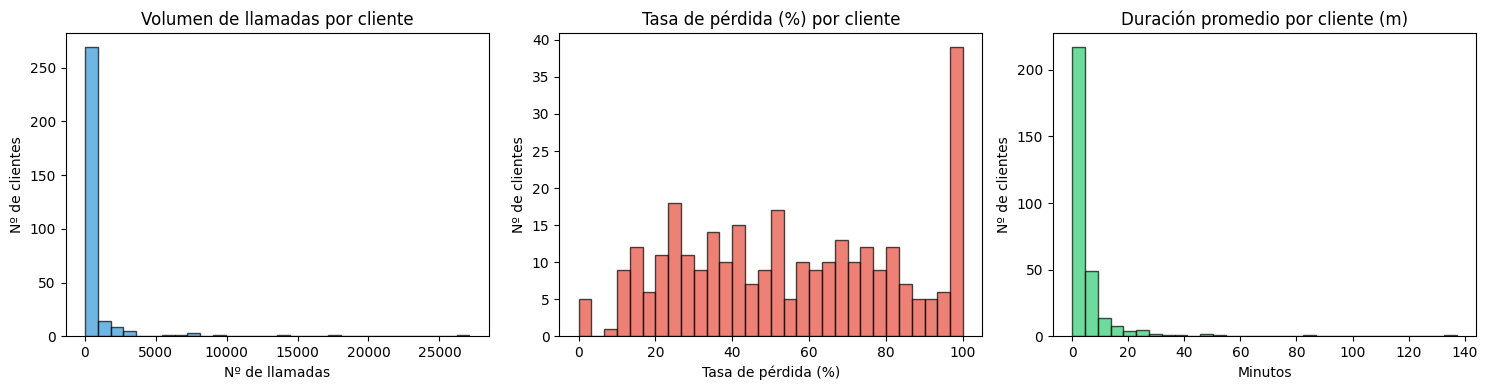

In [30]:

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(clientes_stats["total_llamadas"], bins=30, color="#3498db", edgecolor="black", alpha=0.7)
axes[0].set_title("Volumen de llamadas por cliente")
axes[0].set_xlabel("Nº de llamadas")
axes[0].set_ylabel("Nº de clientes")

axes[1].hist(clientes_stats["tasa_perdida (%)"], bins=30, color="#e74c3c", edgecolor="black", alpha=0.7)
axes[1].set_title("Tasa de pérdida (%) por cliente")
axes[1].set_xlabel("Tasa de pérdida (%)")
axes[1].set_ylabel("Nº de clientes")

axes[2].hist(clientes_stats["duracion_promedio_min"], bins=30, color="#2ecc71", edgecolor="black", alpha=0.7)
axes[2].set_title("Duración promedio por cliente (m)")
axes[2].set_xlabel("Minutos")
axes[2].set_ylabel("Nº de clientes")

plt.tight_layout()
plt.show()


#### Conclusión

* La mayoría de clientes registra pocas llamadas, pero existe una cola larga de clientes con volúmenes muy altos.
* La tasa de pérdida está sesgada hacia valores elevados: muchos clientes pierden más del 50% de sus llamadas.
* La duración promedio muestra que, aunque la mayoría mantiene interacciones cortas, algunos clientes sostienen llamadas muy largas que distorsionan la carga operativa.

### paso 3.2 Panorama global de clientes

In [31]:

def ptab(s):
    q = s.quantile([0.25, 0.50, 0.90, 0.95]).round(2)
    return pd.Series({"p25": q.loc[0.25], "p50": q.loc[0.50], "p90": q.loc[0.90], "p95": q.loc[0.95]})

resumen_clientes_min = pd.DataFrame({
    "métrica": ["volumen_llamadas", "tasa_perdida_%", "duracion_promedio_min"]
}).join(pd.DataFrame([
    ptab(clientes_stats["total_llamadas"]),
    ptab(clientes_stats["tasa_perdida (%)"]),
    ptab(clientes_stats["duracion_promedio_min"])
]).reset_index(drop=True))

resumen_clientes_min


,métrica,p25,p50,p90,p95
0,volumen_llamadas,25.50,85.50,1053.00,2285.25
1,tasa_perdida_%,31.59,53.13,100.00,100.00
2,duracion_promedio_min,0.78,2.13,12.31,21.93


#### Conclusión 

**Volumen de llamadas por cliente**
* El 25% de los clientes hace menos de 26 llamadas en total.
* La mitad hace menos de 86 llamadas.
* Sin embargo, un 10% supera las 1.000 llamadas, y el 5% más activo llega a más de 2.200 llamadas.
* Esto confirma una alta concentración: la mayoría de clientes tiene actividad baja, mientras unos pocos saturan la operación.

**Tasa de pérdida**
* La mediana es de 53%, la mitad de los clientes pierden al menos la mitad de sus llamadas.
* Un 10–15% de clientes directamente tiene 100% de pérdida, es decir, nunca son atendidos.
* La ineficiencia impacta de forma masiva: incluso clientes promedio enfrentan pérdidas graves.

**Duración promedio de llamadas**
* Para la mitad de los clientes, sus llamadas duran en promedio menos de 128 segundos (≈2 minutos).
* Pero en el 10% más alto, las llamadas superan en promedio los 12 minutos, y en el 5% llegan a 22 minutos.
* Esto sugiere que unos pocos clientes consumen tiempos excesivos, lo que amplifica la saturación.

### 3.3 Perfiles de clientes

In [32]:

#  tipos numéricos
for c in ["total_llamadas", "tasa_perdida (%)", "duracion_promedio"]:
    clientes_stats[c] = pd.to_numeric(clientes_stats[c], errors="coerce")

#  Reglas de perfil 
def perfil_cliente(row):
    if row["tasa_perdida (%)"] == 100:
        return "Desatendido"
    if row["total_llamadas"] <= 25 and row["tasa_perdida (%)"] < 50:
        return "Ligero"
    if row["total_llamadas"] >= 1053 and row["tasa_perdida (%)"] > 50:
        return "Problemático"
    if row["total_llamadas"] >= 1053 and row["duracion_promedio"] >= 739:
        return "Intensivo"
    return "Estándar"

clientes_stats["perfil"] = clientes_stats.apply(perfil_cliente, axis=1)

#  Resumen de % clientes y % llamadas por perfil
perfiles_resumen = (
    clientes_stats
    .groupby("perfil", as_index=False)
    .agg(n_clientes=("user_id", "nunique"),
         llamadas=("total_llamadas", "sum"))
)

# Totales para porcentajes
total_clientes_num = int(total_clientes)         
total_llamadas_num = int(total_llamadas)         
perfiles_resumen["% clientes"] = (perfiles_resumen["n_clientes"] / total_clientes_num * 100).round(2)
perfiles_resumen["% llamadas"] = (perfiles_resumen["llamadas"] / total_llamadas_num * 100).round(2)

orden = ["Problemático", "Intensivo", "Desatendido", "Estándar", "Ligero"]
perfiles_resumen["orden"] = perfiles_resumen["perfil"].map({k:i for i,k in enumerate(orden)})
perfiles_resumen = perfiles_resumen.sort_values(["orden","% llamadas"], ascending=[True, False]).drop(columns="orden")

perfiles_resumen.to_csv("perfiles_clientes.csv", index=False)

perfiles_resumen


,perfil,n_clientes,llamadas,% clientes,% llamadas
4,Problemático,9,54134,2.94,27.59
2,Intensivo,16,68639,5.23,34.98
0,Desatendido,33,20471,10.78,10.43
1,Estándar,228,52769,74.51,26.89
3,Ligero,20,211,6.54,0.11


#### Conclusión

| Perfil           | % Clientes | % Llamadas | Lectura ejecutiva                                            |
| ---------------- | ---------- | ---------- | ------------------------------------------------------------ |
| **Problemático** | 2.9%       | 27.6%      | Muy pocos clientes con altísimo volumen y pérdidas elevadas. |
| **Intensivo**    | 5.2%       | 35.0%      | Clientes que generan gran volumen con llamadas muy largas.   |
| **Desatendido**  | 10.8%      | 10.4%      | Nunca reciben atención (100% pérdidas).                      |
| **Estándar**     | 74.5%      | 26.9%      | Mayoría de clientes, con desempeño medio.                    |
| **Ligero**       | 6.5%       | 0.1%       | Clientes con pocas llamadas y baja pérdida.                  |

 
* El 35% del volumen está en clientes intensivos (5%) que saturan la operación con llamadas muy largas.
* Los problemáticos (3% de clientes) concentran otro 28% del volumen, con altas pérdidas.
* Un 11% de clientes directamente nunca es atendido, acumulando 10% del tráfico perdido.
* La gran mayoría (75% de clientes) son estándar, pero apenas generan 27% del tráfico.
* Los clientes ligeros (7%) son marginales y no afectan la operación.
* El servicio no está colapsado de forma homogénea; son pocos clientes los que acaparan la operación y muchos los que no reciben atención. Esto requiere estrategias diferenciadas por perfil.

### Insight global 

* El análisis de clientes confirma que las ineficiencias no son homogéneas. La empresa enfrenta un doble problema:
* Clientes desatendidos que nunca logran contacto.
* Clientes intensivos y problemáticos que consumen recursos desproporcionados.
* Esto refuerza la necesidad de un modelo de atención segmentado, priorizando a los clientes de alto impacto y corrigiendo los casos críticos de desatención.

## Paso 4 Análisis de operadores

### Objetivo

Construir una puntuación clara y comparable entre operadores para identificar:
* Quiénes atienden más volumen.
* Quiénes tienen más/menos pérdidas.
* Quiénes son más lentos o más rápidos.
* Esto nos permite priorizar top operadores críticos para gestión.

### 4.1 Metricas por operador

In [33]:
# Metricas por operadores
operadores_stats = (
    calls[~calls["internal"]]  
    .groupby("operator_id", as_index=False)
    .agg(
        total_llamadas=("calls_count", "sum"),
        llamadas_perdidas=("calls_count", lambda x: calls.loc[x.index, "calls_count"].where(calls.loc[x.index, "is_missed_call"]).sum()),
        duracion_promedio=("total_call_duration", "mean")
    )
)

operadores_stats["tasa_perdida (%)"] = (
    operadores_stats["llamadas_perdidas"] / operadores_stats["total_llamadas"] * 100
).round(2)

operadores_stats = operadores_stats.sort_values(by="total_llamadas", ascending=False).reset_index(drop=True)

operadores_stats["duracion_promedio_min"] = (operadores_stats["duracion_promedio"] / 60).round(2)


operadores_stats.head()


,operator_id,total_llamadas,llamadas_perdidas,duracion_promedio,tasa_perdida (%),duracion_promedio_min
0,885890,60221,23807.0,18908.268775,39.53,315.14
1,885876,59426,23327.0,20402.971530,39.25,340.05
2,929428,23754,19118.0,9741.476923,80.48,162.36
3,925922,20021,9258.0,17158.205479,46.24,285.97
4,908640,14234,8162.0,10801.657895,57.34,180.03


#### Conclusión 

* Hay operadores con tasas de pérdida altísimas (80%), lo que significa que la mayoría de sus clientes nunca reciben atención.
* Los operadores de mayor volumen (60k llamadas) tampoco son eficientes: pierden cerca del 40% de interacciones.
* Algunos operadores presentan tiempos promedio de llamada desproporcionados (200–300 minutos), lo que bloquea capacidad para atender a otros clientes.

El problema no solo viene de los clientes o del sistema, sino también de los operadores. Hay desequilibrios de carga, pérdidas elevadas y gestiones ineficientes que profundizan la saturación del call center.

### 4.2 Top 10 de operadores por tasa de pérdida

In [34]:
# Top 10 operadores por tasa de pérdida
top10_perdidas = operadores_stats.sort_values("tasa_perdida (%)", ascending=False).head(10)

tabla_top10_perdidas = top10_perdidas[[
    "operator_id",
    "total_llamadas",
    "tasa_perdida (%)",
    "duracion_promedio_min"
]]

top10_perdidas.to_csv("operadores_top_perdidas.csv", index=False)

tabla_top10_perdidas


,operator_id,total_llamadas,tasa_perdida (%),duracion_promedio_min
1045,937772,1,100.0,0.30
1000,947480,1,100.0,0.28
742,946454,13,100.0,0.00
1004,894230,1,100.0,0.20
1007,946072,1,100.0,0.02
723,909308,15,100.0,1.94
885,894226,4,100.0,0.30
916,885682,3,100.0,0.28
946,891976,2,100.0,0.38
936,945074,3,100.0,0.43


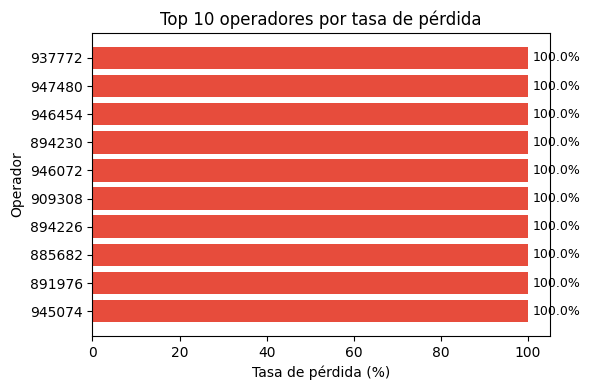

In [35]:

top_pérdidas = operadores_stats.sort_values("tasa_perdida (%)", ascending=False).head(10)

plt.figure(figsize=(6,4))
bars = plt.barh(top_pérdidas["operator_id"].astype(str), top_pérdidas["tasa_perdida (%)"], color="#e74c3c")

plt.xlabel("Tasa de pérdida (%)")
plt.ylabel("Operador")
plt.title("Top 10 operadores por tasa de pérdida")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}%", va="center", fontsize=9)

plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


#### Conclusión 

* Los 10 operadores peor evaluados presentan una tasa de pérdida del 100%: ninguna llamada fue atendida.
* La mayoría de ellos tiene un volumen mínimo (entre 1 y 15 llamadas en total).
* Sus tiempos promedio son casi nulos (menos de 2 minutos en todos los casos), lo que indica que las llamadas se cortan de inmediato.
* Aunque su peso en el volumen global es marginal, su existencia evidencia falta de control de calidad y un riesgo reputacional: incluso con pocos intentos, estos operadores nunca logran atender.

Estos casos deben ser corregidos rápidamente. Si bien no mueven el indicador global de manera significativa, representan “puntos ciegos” de la operación: clientes que nunca reciben atención. Un plan de control de desempeño debe asegurar que ningún operador figure con 100% de pérdidas, aunque tenga bajo volumen.

### 4.3 Top 10 de operadores por volumen

In [36]:
# Top 10 operadores por volumen
top10_volumen = (
    operadores_stats.sort_values("total_llamadas", ascending=False)
    .head(10)[["operator_id", "total_llamadas", "tasa_perdida (%)", "duracion_promedio_min"]]
)

top10_volumen.to_csv("operadores_top_volumen.csv", index=False)

top10_volumen


,operator_id,total_llamadas,tasa_perdida (%),duracion_promedio_min
0,885890,60221,39.53,315.14
1,885876,59426,39.25,340.05
2,929428,23754,80.48,162.36
3,925922,20021,46.24,285.97
4,908640,14234,57.34,180.03
5,929426,11189,56.73,127.45
6,879898,7295,32.15,28.40
7,945286,6873,52.66,83.84
8,945302,6136,51.86,110.85
9,893804,5805,22.19,22.86


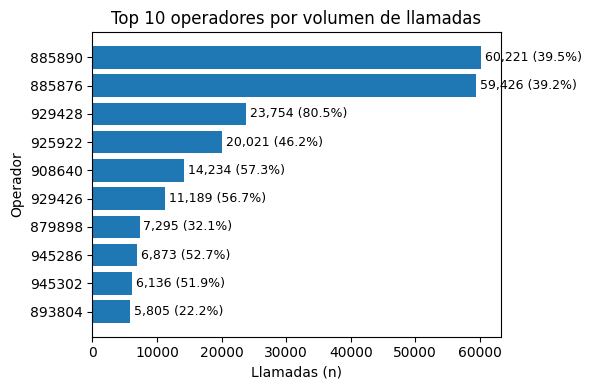

In [37]:

top_volumen = operadores_stats.sort_values("total_llamadas", ascending=False).head(10)

plt.figure(figsize=(6,4))
bars = plt.barh(top_volumen["operator_id"].astype(str), top_volumen["total_llamadas"])

plt.xlabel("Llamadas (n)")
plt.ylabel("Operador")
plt.title("Top 10 operadores por volumen de llamadas")
plt.gca().invert_yaxis()  

for i, bar in enumerate(bars):
    v = bar.get_width()
    pct_loss = top_volumen.iloc[i]["tasa_perdida (%)"]
    plt.text(v + max(top_volumen["total_llamadas"])*0.01,    
             bar.get_y() + bar.get_height()/2,
             f"{int(v):,} ({pct_loss:.1f}%)",
             va="center", fontsize=9)

plt.tight_layout()
plt.show()


#### Conclusión 

* Los 10 operadores con mayor carga gestionan entre 14.000 y 60.000 llamadas cada uno.
* A pesar de su relevancia operativa, sus tasas de pérdida rondan el 40%–60%, lo que implica que casi la mitad de las interacciones no se atienden.
* Sus tiempos promedio de atención son excesivos (180–340 minutos, es decir, entre 3 y 5 horas por llamada).
* Esto indica que incluso los operadores con más volumen presentan ineficiencia estructural: ni la mayor experiencia ni la carga asignada aseguran un mejor desempeño.

El grupo de mayor volumen, que debería ser el más eficiente, también exhibe tasas de pérdida elevadas y tiempos muy largos. Estos operadores impactan directamente en el resultado global y deben ser el foco inmediato de mejora, ya sea con protocolos de atención más ágiles, soporte adicional o redistribución de carga.

#### Insight clave 

* El problema no está solo en los clientes ni en el sistema, también en los operadores:
* Algunos tienen un desempeño nulo (100% pérdidas, aunque con bajo volumen).
* tros, que concentran la mayor carga, muestran ineficiencia estructural: altas pérdidas y tiempos excesivos.

**Acción prioritaria:**

* Implementar un sistema de monitoreo y evaluación por operador, con protocolos claros de desempeño.
* Redistribuir carga y reforzar la formación/soporte en los operadores de mayor volumen.
* Corregir de inmediato los casos de 100% pérdidas para evitar impacto reputacional.

## Paso 5 Análisis por franjas horarias

### 4.4 Análisis por franjas horarias-Distribución de pérdidas por día


In [38]:
# Tasa de pérdida por día de la semana

in_ext["weekday"] = in_ext["date"].dt.day_name(locale="es_ES") 

pérdidas_dia = (
    in_ext.groupby("weekday")
          .agg(total_llamadas=("calls_count","sum"),
               perdidas=("calls_count", lambda x: in_ext.loc[x.index, "calls_count"].where(in_ext.loc[x.index,"is_missed_call"]).sum()))
)
pérdidas_dia["tasa_perdida (%)"] = (pérdidas_dia["perdidas"]/pérdidas_dia["total_llamadas"]*100).round(2)

pérdidas_dia


,total_llamadas,perdidas,tasa_perdida (%)
weekday,,,
Domingo,34428,17937.0,52.10
Jueves,30346,16304.0,53.73
Lunes,37572,19707.0,52.45
Martes,33388,16565.0,49.61
Miércoles,34924,17613.0,50.43
Sábado,9834,5757.0,58.54
Viernes,15732,9496.0,60.36


#### Conclusión 

* El problema es consistente: en todos los días se pierde alrededor de la mitad de las llamadas (50–60%).
* Sin embargo, hay días más críticos:
* Viernes (60.4%) y Sábado (58.5%) muestran las tasas de pérdida más altas.
* Esto sugiere que en el cierre de semana la capacidad del call center es insuficiente para atender la demanda.
* Los mejores días (aunque igualmente malos) son Martes (49.6%) y Miércoles (50.4%), donde la tasa baja ligeramente.

El problema de pérdidas no es exclusivo de ciertos días, sino estructural. Aun así, los picos de ineficiencia en viernes y sábado sugieren que la planificación de personal en fin de semana es insuficiente.

#### 4.5 Distribucion por semana de llamadas perdidas

In [39]:
in_ext["week"] = in_ext["date"].dt.isocalendar().week
in_ext["year"] = in_ext["date"].dt.isocalendar().year

pérdidas_semana = (
    in_ext.groupby(["year","week"])
          .agg(
              total_llamadas=("calls_count","sum"),
              perdidas=("calls_count", lambda x: in_ext.loc[x.index, "calls_count"].where(in_ext.loc[x.index,"is_missed_call"]).sum())
          )
)

pérdidas_semana["tasa_perdida (%)"] = (pérdidas_semana["perdidas"] / pérdidas_semana["total_llamadas"] * 100).round(2)

pérdidas_semana.reset_index(inplace=True)
pérdidas_semana.to_csv("evolucion_semanal.csv", index=False) 

pérdidas_semana


,year,week,total_llamadas,perdidas,tasa_perdida (%)
0,2019,31,19,15.0,78.95
1,2019,32,223,173.0,77.58
2,2019,33,761,485.0,63.73
3,2019,34,1437,833.0,57.97
4,2019,35,2594,1618.0,62.37
5,2019,36,3281,1692.0,51.57
6,2019,37,3915,1902.0,48.58
7,2019,38,4969,2682.0,53.97
8,2019,39,10460,5907.0,56.47
9,2019,40,18631,12460.0,66.88


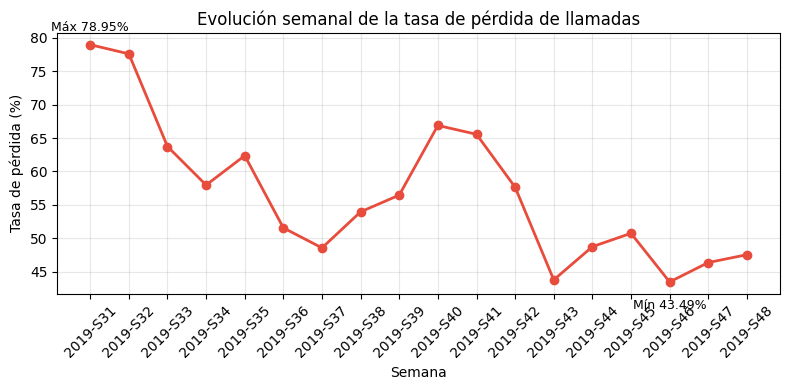

In [40]:

pérdidas_semana["año_semana"] = pérdidas_semana["year"].astype(str) + "-S" + pérdidas_semana["week"].astype(str)

plt.figure(figsize=(8,4))
plt.plot(pérdidas_semana["año_semana"], pérdidas_semana["tasa_perdida (%)"], marker="o", color="#e74c3c", linewidth=2)

plt.xticks(rotation=45)
plt.ylabel("Tasa de pérdida (%)")
plt.xlabel("Semana")
plt.title("Evolución semanal de la tasa de pérdida de llamadas")
plt.grid(alpha=0.3)

max_idx = pérdidas_semana["tasa_perdida (%)"].idxmax()
min_idx = pérdidas_semana["tasa_perdida (%)"].idxmin()

plt.text(pérdidas_semana.loc[max_idx, "año_semana"],
         pérdidas_semana.loc[max_idx, "tasa_perdida (%)"] + 2,
         f"Máx {pérdidas_semana.loc[max_idx, 'tasa_perdida (%)']}%",
         ha="center", fontsize=9, color="black")

plt.text(pérdidas_semana.loc[min_idx, "año_semana"],
         pérdidas_semana.loc[min_idx, "tasa_perdida (%)"] - 4,
         f"Mín {pérdidas_semana.loc[min_idx, 'tasa_perdida (%)']}%",
         ha="center", fontsize=9, color="black")

plt.tight_layout()
plt.show()


#### Conclusión 

* En el inicio del periodo analizado las pérdidas fueron extremadamente altas (77–78%), es decir, casi 8 de cada 10 llamadas no se atendían.
* Posteriormente la tasa bajó hacia el entorno de 43–50%, mostrando cierta mejora.
* Sin embargo, el problema nunca se resolvió: la tasa de pérdida se mantuvo persistentemente elevada, con oscilaciones semana a semana.
* El valor mínimo registrado (~43%) sigue siendo inaceptable para un servicio de atención.

La ineficiencia en la atención no es un hecho aislado de ciertos días, sino un problema crónico y fluctuante en el tiempo. Esto demuestra que no basta con ajustar horarios puntuales: se requieren medidas estructurales en la operación.

## Paso 5 Conclusiones y recomendaciones estratégicas

### Conclusiones globales

**1. Ineficiencia estructural**

* Más de la mitad de las llamadas de clientes se pierden (52.7%), lo que evidencia un colapso en la capacidad de atención.

**2. Clientes**

* La demanda está altamente concentrada: el 5% de clientes genera el 63% de llamadas.
* Un 11% de clientes nunca logra ser atendido (100% pérdidas).
* Los clientes intensivos y problemáticos (8% en total) absorben más del 60% del tráfico.

**3. Operadores**

* Existen casos de operadores con 100% pérdidas, aunque de bajo volumen.
* Los de mayor carga (60.000 llamadas) también muestran 40–60% de pérdidas y duraciones excesivas (3–5 horas por llamada).
* Esto confirma desequilibrios de carga y problemas de eficiencia interna.

**4. Evolución temporal**

* La tasa de pérdida fue alta al inicio (77–78%), luego bajó parcialmente (~43–50%), pero nunca se resolvió.
* El problema es crónico y fluctuante, no puntual.

## Recomendaciones estratégicas

**1. Gestión de la capacidad**

* Reforzar personal en picos semanales (viernes y sábado).
* Redistribuir carga entre operadores para evitar cuellos de botella.

**2. Gestión de operadores**

* Implementar ranking y monitoreo en tiempo real.
* Corregir de inmediato casos con 100% de llamadas perdidas.
* Protocolos de eficiencia para reducir duraciones excesivas.

**3. Gestión de clientes**

* Diseñar un modelo segmentado de atención:
* Clientes intensivos/problemáticos → protocolos especiales, gestores dedicados o planes diferenciados.
* Clientes desatendidos → plan de recuperación inmediata (callbacks, prioridad en cola).

**4. Tecnología y procesos**

* Introducir call-back automático para reducir abandonos en espera.
* Revisar las métricas de calidad, alineándolos con estándares de la industria (<10% de llamadas perdidas).
* Analizar causas internas de llamadas extremadamente largas (fallas en scripts, capacitación o sistemas).

CallMeMaybe enfrenta un problema crónico y estructural de atención: más de la mitad de los clientes no son atendidos y la operación está distorsionada por pocos clientes y operadores críticos.
La solución requiere un enfoque integral: reforzar capacidad en picos, monitorear operadores, segmentar clientes y optimizar procesos. Solo así se podrá recuperar la eficiencia y la satisfacción del cliente.

### Plan 30-60-90 – CallMeMaybe
🔹 **Primeros 30 días (acciones inmediatas)**

1. Control de calidad de operadores: eliminar casos con 100% de llamadas perdidas.
2. Redistribución de carga: equilibrar el tráfico entre operadores de mayor volumen.
3. Refuerzo en picos críticos (viernes y sábado): ajustar turnos de personal.
4. Implementación de monitoreo en tiempo real de la tasa de perdida de llamdas.

🔹 **60 días (acciones de estabilización)**

1. Protocolos de eficiencia para llamadas largas: revisión de scripts y procesos internos.
2. Capacitación focalizada en operadores con mayor duración promedio.
3. Modelo segmentado de atención a clientes:
    * Intensivos/problemáticos → gestores o protocolos especiales.
    * Desatendidos → prioridad en cola o callback automático.
    * Revisión tecnológica: evaluar herramientas de call-back y priorización inteligente de llamadas.

🔹 **90 días (acciones estructurales)**

1. Rediseño de métricas de desempeño: fijar umbrales claros (<10% de llamadas perdidas).
2. Plan de incentivos/desempeño para operadores según tasa de llamadas perdidas y eficiencia.
3. Evaluación de impacto: medir reducción en llamadas perdidas, mejora en tiempos y satisfacción del cliente.

El plan 30-60-90 permite atacar primero los focos urgentes (operadores críticos y picos semanales), luego estabilizar con procesos y capacitación, y finalmente consolidar con tecnología y rediseño estructural.